## Phasenet Download code

In [4]:
# %%capture
# !git clone https://github.com/wuw584/EQNet
# !python -m pip install -r EQNet/requirements.txt

In [4]:
import os
import torch
import numpy as np
import h5py
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

{'dt': 0.01, 'nt': 3000, 'dx': 10, 'nch': 1751, 'GL': 10, 'headers': {'CreationDate': '2025-07-10T11:16:26.852382', 'GaugeLength': 10, 'NumberOfLoci': 1751, 'SpatialSamplingInterval': 10}}


Text(0, 0.5, 'Time (s)')

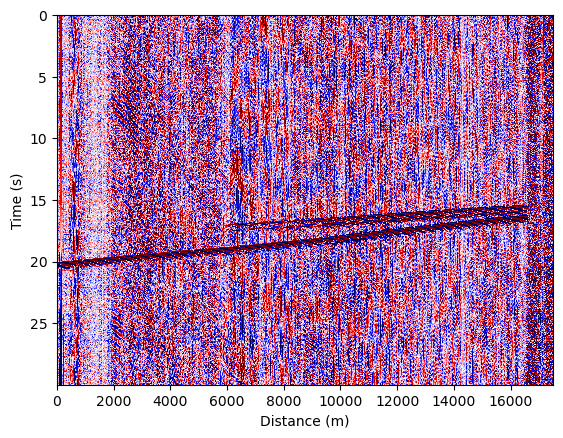

In [10]:
import DasPrep as dp
normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
# h5_files = glob("data/*.h5")
# for file in h5_files:
file = f"/home/disk/disk01/backup/model/EQNet/docs/data/DAS_20250423122300_20250423122330.h5"
data = dp.read_das(file)
metadata = dp.read_das(file , metadata = True)
dt = metadata['dt']
dx = metadata['dx']
nx, nt = data.shape
x = np.arange(nx) * dx
t = np.arange(nt) * dt
print(metadata)
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

In [7]:
normalize = lambda x: (x - np.mean(x, axis=-1, keepdims=True)) / np.std(x, axis=-1, keepdims=True)
# h5_files = glob("data/*.h5")
# for file in h5_files:
file = f"data/DAS_20250423122330_20250423122400.h5"
with h5py.File(file, "r") as fp:
    data = fp["Acquisition/Raw[0]/RawData"][()]
    dt = 1/ fp["Acquisition/Raw[0]"].attrs["OutputDataRate"]

    dx = fp["Acquisition"].attrs["SpatialSamplingInterval"]
    nx, nt = data.shape
    x = np.arange(nx) * dx
    t = np.arange(nt) * dt
        
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/DAS_20250423122330_20250423122400.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Run PhaseNet-DAS

In [5]:
import glob
ngpu = torch.cuda.device_count()
base_cmd = "../predict.py --model phasenet_das --data_list=./files.txt --data_path=./data --result_path ./results --format=h5  --batch_size 1 --workers 0 --system xilisa"

In [7]:
with open("files.txt", "w") as f:
    h5list = glob.glob("/home/disk/disk01/backup/model/EQNet/DAS_data/*.h5")
    
    for i in h5list:f.write(i+"\n") 

if ngpu == 0:
    cmd = f"python {base_cmd} --device cpu"
elif ngpu == 1:
    cmd = f"python {base_cmd}"
else:
    cmd = f"torchrun --nproc_per_node {ngpu} {base_cmd}"

print(cmd)
os.system(cmd)

torchrun --nproc_per_node 2 ../predict.py --model phasenet_das --data_list=./files.txt --data_path=./data --result_path ./results --format=h5  --batch_size 1 --workers 0 --system xilisa


W0716 11:21:05.850000 3204340 site-packages/torch/distributed/run.py:766] 
W0716 11:21:05.850000 3204340 site-packages/torch/distributed/run.py:766] *****************************************
W0716 11:21:05.850000 3204340 site-packages/torch/distributed/run.py:766] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0716 11:21:05.850000 3204340 site-packages/torch/distributed/run.py:766] *****************************************


| distributed init (rank 0): env://
| distributed init (rank 1): env://


/home/wzm/anaconda3/envs/phasenet/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:4631: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
/home/wzm/anaconda3/envs/phasenet/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:4631: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
[rank1]:[W716 11:21:08.833422681 ProcessGroupNCCL.cpp:4718] [PG ID 0 PG GUID 0 Rank 1]  using GPU 1 as device used by this process is currently unknown. This can potentially cause a hang if this rank to GPU mapping is incorrect. You can pecify device_id in init_process_group() to force use of a particular device.
[rank0]:[W716 11:21:08.836723899 ProcessGroupNCCL.cpp:4718] [PG ID 0 PG GUID 0 Rank 0]  using GPU 0 as device used by this process is currently unknown. This c

Namespace(model='phasenet_das', resume='', backbone='unet', phases=['P', 'S'], device='cuda', workers=0, batch_size=1, use_deterministic_algorithms=False, amp=False, world_size=2, dist_url='env://', data_path='./data', data_list='./files.txt', hdf5_file=None, prefix='', format='h5', dataset='das', result_path='./results', plot_figure=False, min_prob=0.3, add_polarity=False, add_event=False, sampling_rate=100.0, highpass_filter=0.0, response_path=None, response_xml=None, subdir_level=0, cut_patch=False, nt=20480, nx=5120, resample_time=False, resample_space=False, system='xilisa', location=None, skip_existing=False, rank=0, gpu=0, distributed=True, dist_backend='nccl')
Total samples: 10 files


Predicting: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]
/home/wzm/anaconda3/envs/phasenet/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:4631: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
Predicting: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]
/home/wzm/anaconda3/envs/phasenet/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:4631: UserWarning: No device id is provided via `init_process_group` or `barrier `. Using the current device set by the user. 
  warnings.warn(  # warn only once
[rank0]:[W716 11:21:17.068709818 ProcessGroupNCCL.cpp:1479] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


0

## Plot results

In [48]:
event_id = "DAS_20250423122300_20250423122330"
# /home/disk/disk01/wzm/EQNet/synthesisdata/DAS_data/DAS_20250423122300_20250423122330 copy.h5
picks = pd.read_csv(f"results/picks_phasenet_das/{event_id}.csv")

Text(0, 0.5, 'Time (s)')

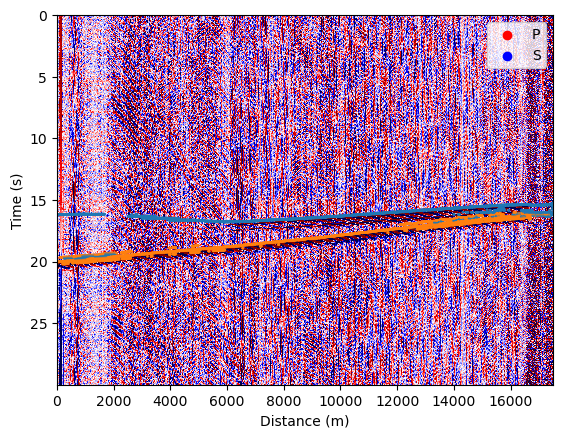

In [49]:
plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
color = picks["phase_type"].map({"P": "C0", "S": "C1"})
plt.scatter(picks["channel_index"].values * dx, picks["phase_index"].values * dt, c=color, s=1)
plt.scatter([], [], c="r", label="P")
plt.scatter([], [], c="b", label="S")
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

# pyocto  install   

In [20]:
!pip install pyocto pyarrow

In [1]:
import pyocto
import pandas as pd
import datetime
import os

In [2]:
result_dir = "./results/pyocto"
data_dir = "./data"
result_path = lambda x: os.path.join(result_dir, x)
data_path = lambda x: os.path.join(data_dir, x)

station_csv = "./data/DAS坐标.txt"
event_id = "DAS_20250423122500_20250423122530"

# event_id = "DAS_20250423122930_20250423123000"
# /home/disk/disk01/wzm/EQNet/synthesisdata/DAS_data/DAS_20250423123230_20250423123300.h5

In [ ]:
picks = pd.read_csv(f"results/picks_phasenet_das/{event_id}.csv")
# picks = pd.read_csv(f"/home/disk/disk01/wzm/EQNet/docs/picks(3).csv")

picks['station_id'] = picks.apply(lambda x: 'CH-'+ str(x['channel_index']).zfill(6), axis=1)
picks['phase_amplitude'] = 200
picks.rename(columns={"station_id": "station", "phase_time": "time", "phase_type": "phase", "phase_score": "prob", "phase_amplitude": "amp"}, inplace=True)
print(picks.head(5))

stations = pd.read_csv(station_csv, sep=',',names=['longitude','latitude', 'elevation_m'])
stations.reset_index(inplace=True)
stations['station_id'] = stations.apply(lambda x: 'CH-'+ str(int(x['index'] )).zfill(6), axis=1)
stations['elevation_m'] = 10
stations.rename(columns={"station_id": "id", "elevation_m": "elevation"}, inplace=True)
print(stations.head(5))
stations= stations.iloc[0:1674:10] # 一千个通道需要比较长的时间，先考虑降采样，计算时间在3min左右
stations.to_csv(result_path("statons.csv"),index = False,sep=' ')
picks = picks[picks['station'].isin(stations['id'])]

velocity_model = pyocto.VelocityModel0D(
    p_velocity=7.0,
    s_velocity=4.0,
    tolerance=2.0,
)
associator = pyocto.OctoAssociator.from_area(
    lat=(29.95, 30.2),
    lon=(121.5, 121.95),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=10,
    n_p_and_s_picks=4,
)
associator.transform_stations(stations)
picks["time"] = pd.to_datetime(picks["time"]).apply(lambda x: x.timestamp())
events, assignments = associator.associate(picks, stations)
associator.transform_events(events)
print(events)
if len(events) > 0:
    events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)
    events.to_csv(result_path("associate_cat.csv"),index=False,sep=',',mode='w')
    associate_list = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
    associate_list.to_csv(result_path("associate_list.csv"),index = False,sep=',')

The required number of P picks per event (3) is lower than the number of stations with both P and S pick (4). The effective number of P picks required will be 4.
The required number of S picks per event (3) is lower than the number of stations with both P and S pick (4). The effective number of S picks required will be 4.


   channel_index  phase_index                     time   prob phase  \
0              0         1423  2025-04-23T12:25:14.230  0.656     P   
1              0         1747  2025-04-23T12:25:17.470  0.777     S   
2              1         1423  2025-04-23T12:25:14.230  0.699     P   
3              1         1747  2025-04-23T12:25:17.470  0.855     S   
4              2         1423  2025-04-23T12:25:14.230  0.742     P   

     station  amp  
0  CH-000000  200  
1  CH-000000  200  
2  CH-000001  200  
3  CH-000001  200  
4  CH-000002  200  
   index   longitude   latitude  elevation         id
0      0  121.823928  30.078215         10  CH-000000
1      1  121.823824  30.078219         10  CH-000001
2      2  121.823724  30.078198         10  CH-000002
3      3  121.823625  30.078171         10  CH-000003
4      4  121.823525  30.078144         10  CH-000004
   idx          time        x         y         z  picks   latitude  \
0    0  1.745411e+09 -0.67876 -2.155952  0.390625    285  

In [ ]:
from pyproj import Geod
def calculate_true_distance(dist_horizontal_m, source_depth_km, inversion_dep_km):
    source_depth_m = source_depth_km *1000
    inversion_dep_m = inversion_dep_km*1000
    dist_vertical_m = source_depth_m - inversion_dep_m 
    dist_true_m = np.sqrt(dist_horizontal_m**2 + dist_vertical_m**2)
    return dist_true_m

def cal_misfit(src_lon,src_lat,src_dep, loc_lon ,loc_lat ,loc_dep):
    geod = Geod(ellps='WGS84')
    #震中距
    dist_horizontal_loc_m = geod.inv(src_lon, src_lat,loc_lon, loc_lat)[2]
    # print(src_lon,src_lat,src_dep, loc_lon ,loc_lat ,loc_dep , dist_horizontal_loc_m)
    #考虑高程差
    return calculate_true_distance(dist_horizontal_loc_m,src_dep,loc_dep)/1000

In [ ]:
import pandas as pd
import os
pyocto_events = pd.read_csv(result_path("associate_cat.csv"), parse_dates=["time"])
source = pd.read_csv(data_path("source(1).txt") ,sep=',',names=['longitude','latitude'])
pyocto_events['src_lon'] = source['longitude']
pyocto_events['src_lat'] = source['latitude']
print(pyocto_events.head())
# pyocto_events['misfit'] = pyocto_events.apply(lambda x: x['latitude']+x['latitude'] )
pyocto_events['misfit'] = pyocto_events.apply(lambda x: cal_misfit(x['longitude'],x['latitude'] , x['depth'] , x['src_lon'],x['src_lat'] ,0) , axis=1)
pyocto_events.to_csv(result_path("source_compare.csv"))
pyocto_events['misfit'].max(),pyocto_events['misfit'].min(),pyocto_events['misfit'].mean()

# cal_misfit(121.66122448979591, 29.991836734693877 ,0, 121.647647,29.961705 ,0.390625  )

   idx                             time         x          y         z  picks  \
0    0 2025-04-23 12:23:13.845175+00:00 -8.823878 -13.423225  4.296875     66   
1    1 2025-04-23 12:23:43.094530+00:00 -7.466359 -12.556512  0.390625     62   
2    2 2025-04-23 12:24:14.270532+00:00 -7.466359  -5.622805  0.390625     54   
3    3 2025-04-23 12:24:41.645538+00:00 -6.108839   0.444188  7.421875     61   
4    4 2025-04-23 12:25:14.636065+00:00 -0.678760  -2.155952  0.390625     58   

    latitude   longitude     depth     src_lon    src_lat  
0  29.953878  121.633590  4.296875  121.661224  29.961224  
1  29.961705  121.647647  0.390625  121.661224  29.991837  
2  30.024254  121.647599  0.390625  121.661224  30.022449  
3  30.078992  121.661637  7.421875  121.661224  30.083673  
4  30.055551  121.717961  0.390625  121.661224  30.114286  


(14.99601430551582, 0.7794415354201294, 5.663305001606327)

[    0     0    10 ... 16730 16740 16740] [16.18 20.   16.17 ... 16.21 15.43 16.21] 0       C0
1       C1
2       C0
3       C1
4       C0
        ..
3263    C1
3264    C0
3265    C1
3266    C0
3267    C1
Name: phase, Length: 3268, dtype: object


Text(0, 0.5, 'Time (s)')

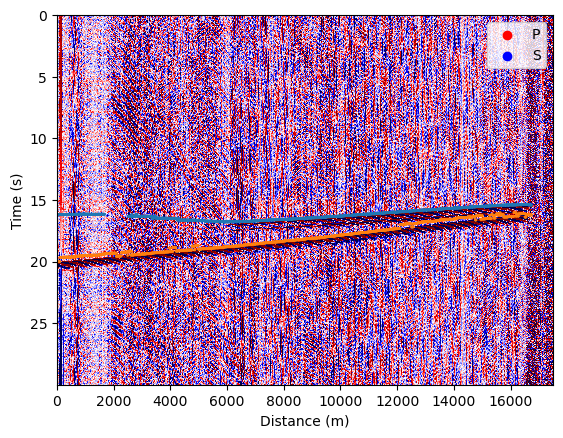

In [12]:
picks = pd.read_csv(f"/home/disk/disk01/backup/model/EQNet/docs/results/pyocto/associate_list.csv",sep=",")

plt.figure()
plt.imshow(normalize(data).T, cmap="seismic", vmin=-1, vmax=1, aspect="auto", extent=[x[0], x[-1], t[-1], t[0]], interpolation="none")
color = picks["phase"].map({"P": "C0", "S": "C1"})
print(picks["channel_index"].values * dx , picks["phase_index"].values * dt,color)
plt.scatter(picks["channel_index"].values * dx, picks["phase_index"].values * dt, c=color, s=1)
plt.scatter([], [], c="r", label="P")
plt.scatter([], [], c="b", label="S")
plt.legend()
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")

# Velest

In [ ]:
#install 
!git clone  https://github.com/wuw584/LOC-FLOW
# !cd LOC-FLOW/src
# !python src/software_download.py

In [14]:
import os
os.chdir("../../LOC-FLOW/")
!python /home/disk/disk01/wzm/LOC-FLOW/alg_velest.py

FileNotFoundError: [Errno 2] No such file or directory: '../../LOC-FLOW/'

In [ ]:
# run_dir = "results/synthesis_data/velest"
# if not os.path.exists(run_dir):
#     os.makedirs(run_dir)
# phaseSA_select = run_dir+"/phaseSA_select.txt"
# phaseSA_best_select = run_dir+"/phaseSA_best_select.txt"
# # os.remove(phaseSA_select)
# # os.remove(phaseSA_best_select)

# channle = []
# num = 0
# # pyocto_events = pd.read_csv(result_path("associate_cat.csv"), parse_dates=["time"])
# event_phase_sel =pd.read_csv(result_path("associate_list.csv"))
# for time,grp in event_phase_sel.groupby('time'):
#     num += 1
#     # print(g.head(5))
#     n_P_picks = len( grp.loc[grp['phase'] == 'P'].drop_duplicates())
#     n_S_picks = len( grp.loc[grp['phase'] == 'S'].drop_duplicates())
#     n_total_picks = len(grp)
#     n_station =  len(grp)-  len( grp['station'].drop_duplicates())
#     grp.loc[:,'station'] =[ int(i.split("-")[-1]) for i in  grp['station']]
#     x,y,z,picks,latitude,longitude,depth = grp.loc[grp.index[0] , ['x' ,'y' , 'z','picks', 'latitude',  'longitude' ,'depth']]
#     grp["time_pick"] = grp["time_pick"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc).__sub__(pd.to_datetime(time)).dt.total_seconds()
#     with open(phaseSA_best_select,'a') as f:
#         g = grp
#         g = g.loc[g['prob'] > 0.4]
#         if len(g)>0:
#             f.write('# {}   {:.4f}   {:.4f}   {:.3f}  {:.2f}    {:.2f}    {:.2f}    {:.2f}      {} \n'.format(pd.to_datetime(time).strftime('%Y %m %d %H %M %S.%f')[:-3], latitude, longitude, depth , 0 ,0, 0, 0, str(num).zfill(6)))
#             for idx, row in g.sort_values(by='prob',ascending=False).head(40).iterrows():

#                 f.write('{}   {:.4f} {:.4f} {}\n'.format(str(row['station']).zfill(5) , row['time_pick'] , row['prob'] , row['phase']))
#                 channle.append(str(row['station']).zfill(5))
#     with open(phaseSA_select,'a') as f:
#         g = grp
#         f.write('# {}   {:.4f}   {:.4f}   {:.3f}  {:.2f}    {:.2f}    {:.2f}    {:.2f}      {} \n'.format(pd.to_datetime(time).strftime('%Y %m %d %H %M %S.%f')[:-3], latitude, longitude, depth , 0 ,0, 0, 0, str(num).zfill(6)))
#         arr = np.linspace(0, len(g)-1, num= min( 500 , len(g)) ,  dtype=int)
#         for idx, row in g.sort_values(by='station').iterrows():
#             if idx in g.index[arr]:
#                 f.write('{}  {:.3f} 1 {}\n'.format(str(row['station']).zfill(5) , row['time_pick'], row['phase']))
#                 channle.append(str(row['station']).zfill(5))


# stations = pd.read_csv(result_path("statons.csv"), sep='\s+')
# stations['station_id'] = [ str(int(i.split('-')[-1])).zfill(5) for i in stations['id'] ]
# stations = stations.loc[stations['station_id'].map(lambda x:x in channle) ]
# stations['elevation_m'] = "1.00"
# stations['HHZ'] = 'DPZ'
# stations['net'] = 'XF'
# stations.to_csv((run_dir+"/station.dat") , columns=["longitude", "latitude", "net", "station_id", "HHZ" ,"elevation_m"] , index=False, header=False , sep=' ' ,float_format='%.6f')
# os.chdir("../../LOC-FLOW/location/VELEST")
# command = "bash ../../LOC-FLOW/location/VELEST/run_velest.sh  1 "
# print(command)
# os.system(command)
# command = "cp ../../LOC-FLOW/location/VELEST/new.cat   "+result_path("velest.cat")
# print(command)
# os.system(command)

bash ../../LOC-FLOW/location/VELEST/run_velest.sh  1 
cp ../../LOC-FLOW/location/VELEST/new.cat   ./results/pyocto/velest.cat


bash: ../../LOC-FLOW/location/VELEST/run_velest.sh: No such file or directory
cp: cannot stat '../../LOC-FLOW/location/VELEST/new.cat': No such file or directory


256

In [ ]:
velest_events = pd.read_csv(result_path("velest.cat"),sep='\s+',header=None, names=['day','hour','minute','seconds','latitude' , 'longitude','depth','mag', 'stationgap' , 'res' , 'event_idx'])
velest_events['year'] = ['20'+str(i)[:2] for i in velest_events['day']]
velest_events['month'] = [str(i)[2:4] for i in velest_events['day']]
velest_events['day'] = [str(i)[4:] for i in velest_events['day']]
velest_events['time'] = pd.to_datetime(velest_events[['year','month' , 'day', 'hour','minute','seconds']] , utc = True)